In [ ]:
import torch
import torch.nn as nn

model = nn.Sequential(

    # 256x256
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),      # 128x128

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),      # 64x64

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),      # 32x32

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(2),      # 16x16

    # 🔥 Global Average Pooling
    nn.AdaptiveAvgPool2d((1, 1)),  # 256x1x1

    nn.Flatten(),                  # 256

    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.4),

    nn.Linear(128, 2)
)


x = torch.randn(1, 3, 256, 256)
print(model(x).shape)


torch.Size([1, 2])


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA available: ", torch.cuda.is_available())
print("GPU name: ", torch.cuda.get_device_name(0))

CUDA available:  True
GPU name:  NVIDIA GeForce RTX 4050 Laptop GPU


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

train_dataset = datasets.ImageFolder("data/train", transform=train_transform)
val_dataset = datasets.ImageFolder("data/val", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
print("Number of training samples: ", len(train_dataset))

Number of training samples:  71071


In [4]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])


In [5]:
print(train_dataset.class_to_idx)
print(val_dataset.class_to_idx)


{'fake': 0, 'real': 1}
{'fake': 0, 'real': 1}


In [ ]:
from collections import Counter
import torch


counter = Counter(train_dataset.targets)
print("Nb_images per class:", counter)



num_classes = len(train_dataset.classes)
total_samples = len(train_dataset)
class_weights = [total_samples / (num_classes * counter[i]) for i in range(num_classes)]
print("Weights per class:", class_weights)

#Pytorch expects class weights as a tensor on the same device as the model
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)


Nb_images per class: Counter({1: 39052, 0: 32019})
Weights per class: [1.1098254161591554, 0.909953395472703]


In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

#Scheduler : divides the LR by 2 if Val Loss doesn't decrease for 2 epochs (patience=2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

In [ ]:
batch_size = 32

In [ ]:
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

num_epochs = 20
best_f1 = 0.0  # Initialisation 

for epoch in range(num_epochs):
    # ================= TRAIN =================
    model.train()
    correct, total, running_loss = 0, 0, 0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        train_bar.set_postfix({"Loss": f"{loss.item():.4f}", "Acc": f"{100*correct/total:.2f}%"})

    train_acc = 100 * correct / total

    # ================= VALIDATION =================
    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    #metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary', pos_label=0
    )
    val_acc = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    val_loss /= len(val_loader)

    # Scheduler update based on Val Loss
    scheduler.step(val_loss)

    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Val Loss: {val_loss:.4f}")
    print(f"🎯 Fake Class (0) -> Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}\n")

    # ================= CHECKPOINT =================
    if f1 > best_f1: 
        best_f1 = f1
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "f1_score": f1,
            "val_loss": val_loss
        }, "best_deepfake_detector.pt")
        print(f"🔥 Nouveau record F1-Score: {f1:.4f}! Modèle sauvegardé.\n")

Epoch 1/20: 100%|██████████| 2221/2221 [03:54<00:00,  9.47it/s, Loss=0.5445, Acc=63.18%]



📊 Epoch 1 Summary:
Train Acc: 63.18% | Val Acc: 65.28% | Val Loss: 0.6219
🎯 Fake Class (0) -> Precision: 0.7121 | Recall: 0.3848 | F1: 0.4996

🔥 Nouveau record F1-Score: 0.4996! Modèle sauvegardé.



Epoch 2/20: 100%|██████████| 2221/2221 [03:55<00:00,  9.45it/s, Loss=0.6398, Acc=69.82%]



📊 Epoch 2 Summary:
Train Acc: 69.82% | Val Acc: 70.38% | Val Loss: 0.5720
🎯 Fake Class (0) -> Precision: 0.6378 | Recall: 0.7927 | F1: 0.7069

🔥 Nouveau record F1-Score: 0.7069! Modèle sauvegardé.



Epoch 3/20: 100%|██████████| 2221/2221 [03:54<00:00,  9.46it/s, Loss=0.5707, Acc=73.39%]



📊 Epoch 3 Summary:
Train Acc: 73.39% | Val Acc: 68.11% | Val Loss: 0.5994
🎯 Fake Class (0) -> Precision: 0.5932 | Recall: 0.9294 | F1: 0.7242

🔥 Nouveau record F1-Score: 0.7242! Modèle sauvegardé.



Epoch 4/20: 100%|██████████| 2221/2221 [03:53<00:00,  9.50it/s, Loss=0.3375, Acc=76.03%]



📊 Epoch 4 Summary:
Train Acc: 76.03% | Val Acc: 78.42% | Val Loss: 0.4576
🎯 Fake Class (0) -> Precision: 0.8207 | Recall: 0.6664 | F1: 0.7356

🔥 Nouveau record F1-Score: 0.7356! Modèle sauvegardé.



Epoch 5/20: 100%|██████████| 2221/2221 [03:53<00:00,  9.51it/s, Loss=0.2881, Acc=78.04%]



📊 Epoch 5 Summary:
Train Acc: 78.04% | Val Acc: 80.88% | Val Loss: 0.4203
🎯 Fake Class (0) -> Precision: 0.8012 | Recall: 0.7655 | F1: 0.7830

🔥 Nouveau record F1-Score: 0.7830! Modèle sauvegardé.



Epoch 6/20: 100%|██████████| 2221/2221 [03:53<00:00,  9.50it/s, Loss=0.3886, Acc=79.57%]



📊 Epoch 6 Summary:
Train Acc: 79.57% | Val Acc: 78.58% | Val Loss: 0.4429
🎯 Fake Class (0) -> Precision: 0.9000 | Recall: 0.5902 | F1: 0.7129



Epoch 7/20: 100%|██████████| 2221/2221 [03:54<00:00,  9.46it/s, Loss=0.3984, Acc=80.83%]



📊 Epoch 7 Summary:
Train Acc: 80.83% | Val Acc: 75.57% | Val Loss: 0.5119
🎯 Fake Class (0) -> Precision: 0.6577 | Recall: 0.9541 | F1: 0.7787



Epoch 8/20: 100%|██████████| 2221/2221 [03:54<00:00,  9.46it/s, Loss=0.4683, Acc=82.23%]



📊 Epoch 8 Summary:
Train Acc: 82.23% | Val Acc: 83.70% | Val Loss: 0.3610
🎯 Fake Class (0) -> Precision: 0.9063 | Recall: 0.7118 | F1: 0.7973

🔥 Nouveau record F1-Score: 0.7973! Modèle sauvegardé.



Epoch 9/20: 100%|██████████| 2221/2221 [03:54<00:00,  9.46it/s, Loss=0.3216, Acc=83.28%]



📊 Epoch 9 Summary:
Train Acc: 83.28% | Val Acc: 81.44% | Val Loss: 0.4038
🎯 Fake Class (0) -> Precision: 0.9345 | Recall: 0.6323 | F1: 0.7542



Epoch 10/20: 100%|██████████| 2221/2221 [03:54<00:00,  9.48it/s, Loss=0.3413, Acc=84.01%]



📊 Epoch 10 Summary:
Train Acc: 84.01% | Val Acc: 69.28% | Val Loss: 0.7369
🎯 Fake Class (0) -> Precision: 0.9793 | Recall: 0.3250 | F1: 0.4880



Epoch 11/20: 100%|██████████| 2221/2221 [03:54<00:00,  9.49it/s, Loss=0.2452, Acc=84.87%]



📊 Epoch 11 Summary:
Train Acc: 84.87% | Val Acc: 85.66% | Val Loss: 0.3217
🎯 Fake Class (0) -> Precision: 0.9097 | Recall: 0.7567 | F1: 0.8262

🔥 Nouveau record F1-Score: 0.8262! Modèle sauvegardé.



Epoch 12/20: 100%|██████████| 2221/2221 [03:54<00:00,  9.48it/s, Loss=0.4539, Acc=85.63%]



📊 Epoch 12 Summary:
Train Acc: 85.63% | Val Acc: 74.32% | Val Loss: 0.5816
🎯 Fake Class (0) -> Precision: 0.6415 | Recall: 0.9745 | F1: 0.7737



Epoch 13/20: 100%|██████████| 2221/2221 [03:53<00:00,  9.50it/s, Loss=0.4012, Acc=86.35%]



📊 Epoch 13 Summary:
Train Acc: 86.35% | Val Acc: 87.70% | Val Loss: 0.2876
🎯 Fake Class (0) -> Precision: 0.9418 | Recall: 0.7747 | F1: 0.8502

🔥 Nouveau record F1-Score: 0.8502! Modèle sauvegardé.



Epoch 14/20: 100%|██████████| 2221/2221 [03:53<00:00,  9.52it/s, Loss=0.4558, Acc=86.77%]



📊 Epoch 14 Summary:
Train Acc: 86.77% | Val Acc: 78.92% | Val Loss: 0.4789
🎯 Fake Class (0) -> Precision: 0.9763 | Recall: 0.5452 | F1: 0.6997



Epoch 15/20: 100%|██████████| 2221/2221 [03:53<00:00,  9.52it/s, Loss=0.4889, Acc=87.54%]



📊 Epoch 15 Summary:
Train Acc: 87.54% | Val Acc: 85.48% | Val Loss: 0.3431
🎯 Fake Class (0) -> Precision: 0.9620 | Recall: 0.7056 | F1: 0.8141



Epoch 16/20: 100%|██████████| 2221/2221 [03:53<00:00,  9.52it/s, Loss=0.2124, Acc=88.15%]



📊 Epoch 16 Summary:
Train Acc: 88.15% | Val Acc: 88.76% | Val Loss: 0.2618
🎯 Fake Class (0) -> Precision: 0.8777 | Recall: 0.8721 | F1: 0.8749

🔥 Nouveau record F1-Score: 0.8749! Modèle sauvegardé.



Epoch 17/20: 100%|██████████| 2221/2221 [03:53<00:00,  9.50it/s, Loss=0.3920, Acc=88.38%]



📊 Epoch 17 Summary:
Train Acc: 88.38% | Val Acc: 84.52% | Val Loss: 0.3513
🎯 Fake Class (0) -> Precision: 0.9713 | Recall: 0.6764 | F1: 0.7975



Epoch 18/20: 100%|██████████| 2221/2221 [03:54<00:00,  9.49it/s, Loss=0.4014, Acc=88.85%]



📊 Epoch 18 Summary:
Train Acc: 88.85% | Val Acc: 89.41% | Val Loss: 0.2482
🎯 Fake Class (0) -> Precision: 0.8586 | Recall: 0.9157 | F1: 0.8862

🔥 Nouveau record F1-Score: 0.8862! Modèle sauvegardé.



Epoch 19/20: 100%|██████████| 2221/2221 [03:54<00:00,  9.48it/s, Loss=0.2096, Acc=89.22%]



📊 Epoch 19 Summary:
Train Acc: 89.22% | Val Acc: 86.81% | Val Loss: 0.3160
🎯 Fake Class (0) -> Precision: 0.7886 | Recall: 0.9664 | F1: 0.8685



Epoch 20/20: 100%|██████████| 2221/2221 [03:55<00:00,  9.45it/s, Loss=0.2533, Acc=89.55%]



📊 Epoch 20 Summary:
Train Acc: 89.55% | Val Acc: 91.81% | Val Loss: 0.2091
🎯 Fake Class (0) -> Precision: 0.9064 | Recall: 0.9124 | F1: 0.9094

🔥 Nouveau record F1-Score: 0.9094! Modèle sauvegardé.



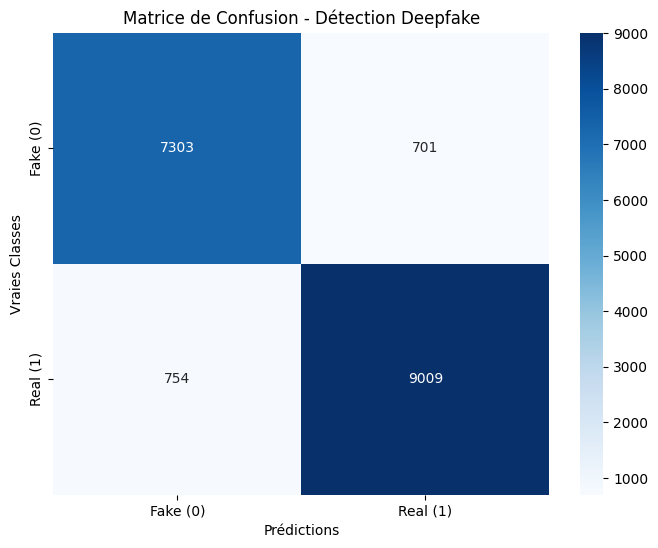

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calcul de la matrice
    cm = confusion_matrix(all_labels, all_preds)
    
    # Affichage
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Fake (0)', 'Real (1)'], 
                yticklabels=['Fake (0)', 'Real (1)'])
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies Classes')
    plt.title('Matrice de Confusion - Détection Deepfake')
    plt.show()


checkpoint = torch.load("best_deepfake_detector.pt")
model.load_state_dict(checkpoint['model_state_dict'])


plot_confusion_matrix(model, val_loader, device)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


checkpoint = torch.load("best_deepfake_detector.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


cm = confusion_matrix(all_labels, all_preds)
print("--- Matrice de Confusion Brute ---")
print(cm)
print("\n--- Rapport de Classification ---")
print(classification_report(all_labels, all_preds, target_names=['Fake', 'Real']))

--- Matrice de Confusion Brute ---
[[7303  701]
 [ 754 9009]]

--- Rapport de Classification ---
              precision    recall  f1-score   support

        Fake       0.91      0.91      0.91      8004
        Real       0.93      0.92      0.93      9763

    accuracy                           0.92     17767
   macro avg       0.92      0.92      0.92     17767
weighted avg       0.92      0.92      0.92     17767

